# 1. Importing data

In [1]:
import pandas as pd
import json
import numpy as np
import re
from sklearn.utils import resample
import matplotlib.pyplot as plt
from strsimpy.qgram import QGram
from sklearn.cluster import AgglomerativeClustering

from pytextdist.vector_similarity import qgram_similarity
from pytextdist.vector_similarity import cosine_similarity
from strsimpy.normalized_levenshtein import NormalizedLevenshtein

#Import data
data = json.load(open('TVs-all-merged.json')) 

#Create list of different products in dictionaries
products = []
for keys in data.keys():
    for product in data[str(keys)]:
        products.append(product)

## 2. All functions

### Functions to apply bootstrapping

In [2]:
def bootstrap():
    data_length = list(range(0,1624))

    bootstrap_train = resample(data_length, replace=True, n_samples=len(data_length)) #1624
    bootstrap_test = [x for x in data_length if x not in bootstrap_train]
    return bootstrap_train, bootstrap_test


#Need to use 5 bootstraps

In [3]:
def unique_values(data: list):
    unique_values = []
    for x in data:
        if x not in unique_values:
            unique_values.append(x)
    return unique_values

### Functions to get right amount of data

In [4]:
def products_train(train_data):
    products_train = []
    for product_index in train_data:
        products_train.append(products[product_index])
    return products_train

def products_test(test_data):
    products_test = []
    for product_index in test_data:
        products_test.append(products[product_index])
    return products_test

### Functions to obtain specific keys

In [5]:
def get_product_titles(products):
    get_product_titles = []
    for product in range(0, len(products)):
        get_product_titles.append(products[product]['title'])
    return get_product_titles

In [6]:
def get_features_map(products):
    get_features_map = []
    for product in range(0, len(products)):
        get_features_map.append(products[product]['featuresMap'])
    return get_features_map

### Functions to clean the title

In [7]:
def title_cleaning(product_titles):
    for index in range(0, len(product_titles)):
        for replacement in ['Inch', 'inches', '"', '-inch', ' inch', 'inch']:
            product_titles[index] = product_titles[index].replace(str(replacement), 'inch')    
    for index in range(0, len(product_titles)):
        for replacement in ['Hertz', 'hertz', 'Hz', 'HZ', ' hz', '-hz', 'hz']:
            product_titles[index] = product_titles[index].replace(str(replacement), 'hz')
    return product_titles

### Functions to get the model words from all titles

In [8]:
def model_words_unique(list_with_strings):
    model_words = []
    for string in list_with_strings: 
        model_words.append(re.findall('([a-zA-Z0-9]*(([0-9]+[ˆ0-9, ]+)|([ˆ0-9, ]+[0-9]+))[a-zA-Z0-9]*)', string))

    list_first_mw = []
    for model_word in model_words:
        for tupel in model_word:
            list_first_mw.append(tupel[0])
        
    unique_model_words = []
    for string in list_first_mw:
        if string not in unique_model_words:
            unique_model_words.append(string)
    return unique_model_words

In [9]:
def extract_featuresM_MW(key_value_FM):
    
    lijst52 = []
    for i in range(0,len(key_value_FM)):
        lijst51 = []
        for value in key_value_FM[i].values(): #run with (^nd+(n.nd+)?[a-zA-Z]+$j^nd+(n.nd+)?$)
            if re.findall('([a-zA-Z0-9]*(([0-9]+[ˆ0-9, ]+)|([ˆ0-9, ]+[0-9]+))[a-zA-Z0-9]*)', value) != []:
                model_word = re.findall('([a-zA-Z0-9]*(([0-9]+[ˆ0-9, ]+)|([ˆ0-9, ]+[0-9]+))[a-zA-Z0-9]*)', value)
                lijst51.append(model_word)
        lijst52.append(lijst51)

    lijst53 = []

    for model_word in lijst52:
        lijst55 = []
        for word in model_word:
            for tupel in word:
                lijst55.append(tupel[0])
        lijst53.append(lijst55)
    return lijst53

### Functions to create the binary vector

In [10]:
def model_word_in_title(model_word_list, title_list):
    model_word_pertitle = []
    for title in title_list:
        temporary_list = []
        for model_word in model_word_list:
            if model_word in title:
                temporary_list.append(1)
            else: 
                temporary_list.append(0)
        model_word_pertitle.append(temporary_list)
    return pd.DataFrame(model_word_pertitle, index=title_list,columns=model_word_list).T

In [11]:
def model_word_in_KV(model_word_list, model_word_pertitle, KV_list_per_product):
    model_word_pertitle2 = model_word_pertitle
    
    for i in range(0,len(KV_list_per_product)):
        for value in KB_list[i]:
            temporary_list2 = []
            for model_word in model_word_list:
                if model_word in value:
                    temporary_list2.append(1)
            else: 
                temporary_list2.append(0)
        #model_word_pertitle.append(temporary_list)
    return #pd.DataFrame(model_word_pertitle, index=title_list,columns=model_word_list).T       

In [12]:
def model_word_in_title_KV(model_word_list, title_list, KV_list_per_product):
    model_word_pertitle = []
    for i in range(0,len(title_list)):
        temporary_list = []
        for model_word in model_word_list:
            if model_word in title_list[i] or model_word in KV_list_per_product[i]:
                temporary_list.append(1)
            else: 
                temporary_list.append(0)
        model_word_pertitle.append(temporary_list)
    return pd.DataFrame(model_word_pertitle, index=title_list,columns=model_word_list).T

### Function to apply minHasing

In [13]:
def minhash(binary_vector, n):
    df = binary_vector.reset_index()
    df = df.drop(columns=['index'])

    df_minhash = df[0:0]
    first_list = []
    for permutation in range(0, n):
        first_list = []
        df_shuffled = df.iloc[np.random.permutation(df.index)].reset_index(drop=True)
        for column in range(0, len(df_minhash.columns)):
            first_list.append((df_shuffled.iloc[:, column] == 1).argmax())
        df_minhash = df_minhash.append(pd.DataFrame([first_list], columns=df_minhash.columns), ignore_index=True)
    return df_minhash

### Function to create the signature matrix

In [14]:
def buckets(df_minhash, r):
    i = r
    j = 0
    k = 0
    lijst12 = []
    for column in range(0,len(df_minhash.columns)):
        lijst13 = []
        while j < len(df_minhash)/r:
            lijst11 = ''
            j= j+1
            lijst11 = lijst11 + (" ".join(str(elem) for elem in df_minhash.values[i-r:i, column]).replace(" ", ""))
            i= i+r
            lijst13.append(lijst11)
        lijst12.append(lijst13)
        i = r
        j = 0
        k = k +1
    df_signature_matrix = pd.DataFrame(lijst12).T
    return df_signature_matrix

### Function to appy LSH

In [15]:
def lsh(df_lsh):
    big_list = []
    for j in range(0,len(df_lsh.columns)):
        test = np.zeros((len(df_lsh.index), len(df_lsh.columns)), bool)
        for i in range(0,len(df_lsh.index)):
                test[i] = df_lsh.values[i][j]== df_lsh.values[i]
        test2 = np.where(test is True,1,test)
        test2 = np.where(test2 is False,0,test2)
        agg = np.max(test2, axis=0)
        big_list.append(agg)
    final_LSH = pd.DataFrame(np.row_stack(big_list))
    final_LSH = final_LSH.mask(np.tril(np.ones(final_LSH.shape, dtype=np.bool_))).replace(np.nan, 0)    
    return final_LSH

### Functions for the performance evaluations

In [16]:
def TP(duplicates):
    return duplicates

In [17]:
def FP(number_comp_made, duplicates):
    return (number_comp_made - duplicates)

In [18]:
def TN(predicted_non_duplicates, duplicates, total_duplicates):
    return (predicted_non_duplicates - (total_duplicates - duplicates))

In [19]:
def FN(total_duplicates, duplicates):
    return (total_duplicates - duplicates)

In [20]:
def precision(TP, FP):
    return (TP / (TP + FP)) if (TP + FP) != 0 else 0

In [21]:
def recall(TP, FN):
    return (TP / (TP + FN)) if (TP+ FN) != 0 else 0

In [22]:
def F1_score(precision, recall):
    return (2 * ((precision*recall)/(precision+recall))) if (recall+ precision) != 0 else 0

In [23]:
def calculate_avg(results : list):
    avg = []
    for i in range(0,len(results[0])):
        column = 0
        for j in range(0,len(results)):
            column +=results[j][i]
            
        avg.append(column/5)
    return avg

### Functions for the similarity measure

In [24]:
def get_product_shops(products):
    get_product_shops = []
    for product in range(0, len(products)):
        get_product_shops.append(products[product]['shop'])
    return get_product_shops

In [25]:
def get_product_modelIDs(products):
    get_product_modelIDs = []
    for product in range(0, len(products)):
        get_product_modelIDs.append(products[product]['modelID'])
    return get_product_modelIDs

In [26]:
def calcQgramSim(a,b,title_list,qgram): #1 is most similar
    qgramSim = (len(title_list[a]) + len(title_list[b]) - qgram.distance(title_list[a],title_list[b]))/(len(title_list[a]) + len(title_list[b]))
    return qgramSim

In [27]:
def MSM_LT(products_totrain,lsh_arr):
    shops = get_product_shops(products_totrain)
    shops = np.array(shops)      

    dist = np.empty((len(shops), len(shops)), float)
    dist = shops[None, :] == shops[:, None]
    dist = np.where(dist == 1,1000.5,dist)

    df_dist = pd.DataFrame(dist)
    df_dist

    df_title = pd.DataFrame()
    title_list = get_product_titles(products_totrain)
    df_title['brand'] = range(len(title_list))
    df_title['brand'] = df_title['brand'].astype(str)
    brands_list = ['Acer','SuperSonic', 'Admiral', 'Admiral Overseas Corporation (AOC)', 'Advent', 'Adyson', 'Asianet Digital LED TV', 'Agath', 'Agrexsione', 'Aiwa', 'Akai', 'Akari', 'Akurra', 'Alba (Harvard)', 'Amplivision', 'Amstrad', 'Andrea Electronics', 'Anitech', 'Apex Digital', 'Arcam', 'Arena', 'Argosy Radiovision', 'Arise India', 'AGA', 'Astor', 'Asuka', 'Atlantic', 'Atwater Television', 'Audar', 'Automatic Radio Manufacturing', 'Audiovox', 'AVEL', 'AVol', 'AWA', 'Bace Television', 'Baird', 'Bang & Olufsen', 'Baumann Meyer', 'Beko', 'BenQ', 'Bell Television', 'BelTek Tv', 'Bharat', 'Beon', 'Binatone', 'BiSA', 'Bitova electronika', 'Blaupunkt', 'BLUE Edge', 'Blue Sky', 'Blue Star', 'Bondstec', 'BOSE', 'BPL india lmt', 'Brandt', 'Brionvega', 'Britannia', 'BrokSonic', 'BSR', 'BTC', 'Bush', 'Calbest Electronics', 'Caixun', 'Capehart Electronics', 'Carrefour', 'Cascade', 'Cathay', 'Cello Electronics', 'Centurion', 'Certified Radio Labs', 'Cenfonix', 'CGE', 'Changhong', 'ChiMei', 'Cimline', 'Citizen', 'Clairetone Electric Corporation', 'Clarivox', 'Clatronic', 'CloudWalker[1]', 'Coby', 'Colonial Radio (Sylvania)', 'Color Electronics Corporation', 'Compal Electronics[2][3]', 'Conar Instruments', 'Condor', 'Conrac (Monitors)', 'Conrac (Germany)', 'Contec', 'Continental Edison', 'Cortron Industries (Hoffman)', 'Cossor', 'Craig', 'Crown', 'Crystal', 'CS Electronics', 'CTC', 'Curtis Mathes Corporation', 'Cybertron', 'Daewoo', 'Dainichi', 'Damro', 'Dansai', 'Dayton', 'De Graaf', 'Decca', 'Deccacolour (UK)', 'Defiant', 'Dell', 'Delmonico International Corporation', 'Diamond Vision', 'Diboss', 'Digihome', 'Dixi', 'Dual', 'Dual Tec', 'Dumont', 'DuMont Laboratories', 'Durabrand', 'Dyanora (India)', 'Dynatron', 'Dynex', 'Edler', 'Electron', 'Electronics Corp. (ECTV India)', 'English Electric', 'English Electric Valve Company', 'EKCO', 'Elbe', 'Electrohome', 'Element', 'Elin', 'Elite', 'Elta', 'Emerson', 'Emerson', 'EMI', 'Erres', 'Expert', 'Farnsworth', 'Ferguson Electronics', 'Ferranti', 'Fidelity Radio', 'Finlandia', 'Finlux (Vestel)', 'FIRST', 'Firstline', 'Fisher Electronics', 'Fleetwood (CONRAC)', 'Flint', 'Formenti', 'Frontech', 'Fujitsu', 'Funai', 'GC', 'Geloso', 'General Electric', 'General Electric Company', 'General Gold', 'Geloso', 'Genexxa', 'GoldStar', 'Goodmans Industries', 'Gorenje', 'GPM', 'Gradiente', 'Graetz', 'Granada', 'Grandin', 'Grundig', 'Haier', 'Hallicrafters', 'Hannspree', 'Hanseatic', 'Hantarex', 'Harvard International', 'Harvey Industries', 'Haver Electric', 'HCM', 'Healing', 'Helkama', 'Helvar', 'Heath Company/Heathkit', 'Hesstar', 'Hinari Domestic Applicanes', 'Hisawa', 'HMV', 'Hisense', 'Hitachi', 'HKC', 'Hoffman Television (Cortron Ind)', 'Horizont', 'Howard Radio (Muntz)', 'Huanyu', 'Hypson', 'Ice', 'Ices', 'Inelec[4]', 'ITS', 'ITT Corporation', 'ITT-KB (UK)', 'ITT-SEL (Germany)', 'Imperial', 'INB', 'Indiana', 'Ingelen', 'Inno Hit', 'Innovex', 'Insignia', 'Interfunk', 'Intervision', 'Isukai', 'IZUMI', 'Jensen Loudspeakers', 'JMB', 'Joyeux', 'Kaisui', 'Kamacrown', 'Kane Electronics Corporation', 'Kapsch', 'Kathrein', 'Kendo', 'Kenmore', 'Kent Television', 'Khind', 'Kingsley', 'KIVI (Ukraine)', 'Kloss Video', 'Kneissel', 'Kogan', 'Kolster-Brandes', 'Konka', 'Korpel', 'Koyoda', 'Kreisler', 'KTC', 'Lanix', 'Le.com', 'Leyco', 'LG', 'Liesenkötter', 'Linsar', 'LLoyds', 'Loewe', 'Luma', 'Luxor', 'M Electronic', 'MTC', 'Magnadyne', 'Magnafon', 'Magnasonic', 'Magnavox', 'Magnavox (subsidiary of Philips)', 'Maneth', 'Marantz', 'Marconiphone', 'Mark', 'Matsui', 'Mattison Electronics', 'McMichael Radio', 'Mediator (brand name owned by Philips)', 'Memorex', 'Micromax', 'Mercury-Pacific', 'Metz', 'Minerva', 'Minoka', 'Mirc Electronics (Onida brand; India)', 'Mitsubishi', 'Mivar', 'Mi TV', 'Mobile360 Tv', 'Motorola', 'Multitech (brand name only)', 'Muntz (Howard Radio)', 'MT Logic (related to Multitech, brand name only)', 'Murphy Radio', 'NASCO ELECTRONICS', 'NEC', 'Neckermann', 'Nelco', 'NEI', 'NEOS', 'NetTV', 'Nikkai', 'Nobliko', 'Nokia', 'Nordmende', 'North American Audio', 'Olympic Radio and Television', 'Oceanic', 'oCosmo', 'OK tv', 'Olevia', 'One', 'OnePlus', 'Onida', 'Onwa', 'Orion (Hungary)', 'Orion (Japan)', 'Osaki', 'Oso', 'Osume', 'Otake', 'Otto Versand', 'Palladium', 'Panama', 'Panasonic (National)', 'Pathe Cinema', 'Pathe Marconi', 'Pausa', 'Perdio', 'Pensonic', 'Peto Scott', 'Philco (Philco-Ford)', 'Philips', 'Philmore Manufacturing', 'Phonola', 'Pilot Radio', 'Pilot Radio Corporation (Jerrold Electronics)', 'Pioneer', 'Planar Systems', 'Polar', 'Polaroid', 'Profilo Holding (brand Telefunken)', 'Profex', 'Prima', 'Privé', 'ProLine', 'ProScan', 'ProTech', 'Pulser (own by Canadian tire)', 'Pye', 'Pyle', 'PyxScape', 'Quasar', 'Quelle', 'Questa', 'R-Line', 'REI', 'Radiola', 'Radiola (France, owned by Philips)', 'RadioMarelli', 'RadioShack', 'Rank Arena', 'Ravenswood', 'Rauland Borg', 'RBM', 'RCA', 'RCA (HKC', 'Realistic', 'Rediffusion', 'Regentone', 'Revox', 'Rex', 'RFT (Stassfurt plant)', 'RGD (Radio Gramaphone Development Company)', 'Roadstar', 'Rolls', 'Rolsen Electronics', 'Rubin', 'SABA', 'Saccs', 'Saisho', 'Salora', 'Salora International', 'Sambers', 'Sampo Corp. of America', 'Samsung', 'Sanabria Television Corporation', 'Sandra', 'Sansui', 'Sanyo', 'SBR', 'Sceptre', 'Schaub Lorenz', 'Schneider Electric', 'Schneider', 'Schneider', 'Sears (Silvertone)', 'SEG', 'SEI', 'Sei-Sinudyne', 'Seiki Digital', 'Selco (India)', 'Sèleco', 'Sentra', 'Setchell Carlson', 'Seura', 'Sharp', 'Airis', 'Shinco', 'Shorai', 'Siarem', 'Siemens', 'Silo Digital', 'Skywalker', 'Silvertone', 'Sinudyne', 'Skyworth', 'Sobell[6][7]', 'Solavox', 'Soniq', 'Sonitron', 'Sonodyne', 'Sonoko', 'Sonolor', 'Sonora', 'Sontec', 'Sony', 'Soyo', 'Soundwave', 'Softlogic', 'Sparc', 'Stern-Radio Staßfurt', 'Stromberg Carlson', 'Stewart-Warner', 'SunLite TV', 'Sunkai', 'Susumu', 'Supersonic', 'Supra', 'Sylvania', 'Symphonic Electronic Corp', 'Symphonic Radio and Electronics', 'Sysline', 'Tandy', 'Technika TV', 'Tatung Company', 'TCL', 'Tec', 'Tech-Master', 'Technema', 'Technics', 'Technisat', 'Tecnimagen', 'Technika', 'TECO', 'Teleavia', 'Telebalt', 'Telefunken', 'Telemeister', 'Telequip', 'Teletech', 'Teleton', 'Teletronics', 'Television, Inc.', 'Temp', 'Tensai', 'Texet', 'Thomson SA']
    for i in range(0,len(title_list)):
        for j in range(0,len(brands_list)):
            if brands_list[j] in title_list[i]:
                df_title['brand'].values[i] = brands_list[j]

    brands_list = df_title.brand
    dist_brands = brands_list[None, :] == brands_list[:, None]
    dist_brands = np.where(dist_brands == 0,1000.5,dist_brands)

    df_dist_brands = pd.DataFrame(dist_brands)
    df_dist_brands
    dist = np.where(dist_brands == 1000.5,1000.5,dist)
    df_dist = pd.DataFrame(dist)
    df_dist

    modelIDs = get_product_modelIDs(products_totrain)

    alpha = 0.612
    beta = 0.24
    mu = 0.65
    gamma = 0.756
    qgram = QGram(3)
    n = len(dist)
    for i in range(0,n):
        print(i)
        for j in range(0,n):
                if (lsh_arr[i,j] == 1) | (lsh_arr[j,i] == 1):
                    if (dist[i,j] != 1000.5):
                        titleSim = calcQgramSim(i,j,title_list,qgram)
                        dist[i,j] = dist[j,i] = (1-titleSim)
                else:
                    dist[i,j] = dist[j,i] = 1000.5

    clust = AgglomerativeClustering(distance_threshold=0.5, affinity='precomputed', n_clusters=None,linkage='complete').fit_predict(dist)

    df_dist = pd.DataFrame(data=clust,columns=['Cluster'])
    df_dist['modelID']= modelIDs

    grouped_df = df_dist.groupby("Cluster")
    cluster = grouped_df['modelID'].apply(list)
    cluster = cluster.reset_index()

    correctpositives = 0
    false_positives = 0
    for i in range(0,len(cluster.modelID)):
        for q in range(0,len(cluster.modelID[i])):
            for r in range(0,len(cluster.modelID[i])):
                if r > q:
                        #print(cluster.modelID[i][q], cluster.modelID[i][r], cluster.modelID[i][q] == cluster.modelID[i][r])
                        if cluster.modelID[i][q] == cluster.modelID[i][r]:
                            correctpositives = correctpositives + 1
                        else:
                            false_positives = false_positives + 1
    print(correctpositives,false_positives)
    cluster

    grouped_df = df_dist.groupby("modelID")
    cluster_modelID = grouped_df['Cluster'].apply(list)
    cluster_modelID = cluster_modelID.reset_index()
    cluster_modelID

    correct_negatives = 0
    false_negatives = 0
    for i in range(0,len(cluster_modelID.Cluster)):
        for q in range(0,len(cluster_modelID.Cluster[i])):
            for r in range(0,len(cluster_modelID.Cluster[i])):
                if r > q:
                        #print(cluster_modelID.Cluster[i][q], cluster_modelID.Cluster[i][r], cluster_modelID.Cluster[i][q] == cluster_modelID.Cluster[i][r])
                        if cluster_modelID.Cluster[i][q] == cluster_modelID.Cluster[i][r]:
                            correct_negatives = correct_negatives + 1
                        else:
                            false_negatives = false_negatives + 1
    print(correct_negatives,false_negatives)

    F1 = F1_score(precision(correctpositives,false_positives),recall(correctpositives,false_negatives))
    return F1

## 3. Code to run

In [28]:
duplicate_list2 = []
number_p_comp_list2 = []
number_comp_made_list2 = []
fraction_comp_list2 = []
total_duplicates_list2 = []
predicted_non_duplicates_list2 = []
PQ_list2 = []
PC_list2 = []
TP_list2 = []
FP_list2 = []
TN_list2 = []
FN_list2 = []
precision_list2 = []
recall_list2 = []
F1_star_list2 = []
F1_score_list2 = []
F1_MSM_list2 = []

repeats = 0
while repeats <= 4:   
    train_and_test_split = bootstrap()

    #Create train and test data
    train_data = train_and_test_split[0]
    train_data = unique_values(train_data)

    #Assign train and test data
    products_totrain = products_train(train_data)

    #Get product titles
    product_titles_totrain = get_product_titles(products_totrain)

    #Clean titles wrt inch and hz
    cleaned_product_titles_totrain = title_cleaning(product_titles_totrain)

    #Get first model word from titles
    unique_title_mw_train = model_words_unique(cleaned_product_titles_totrain)
    unique_title_mw_train = list(set([x.strip() for x in unique_title_mw_train]))

    
    #Check if model word in title and create binary vector
    df_binary_vector_train = model_word_in_title_KV(unique_title_mw_train, cleaned_product_titles_totrain, extract_featuresM_MW(get_features_map(products_totrain)))

    #Minhashing
    df_minhash_train = minhash(df_binary_vector_train, round(0.5*len(unique_title_mw_train))) #n is equal to 50% of data

    #LSH + LSH evaluation
    duplicate_list = []
    number_p_comp_list = []
    number_comp_made_list = []
    fraction_comp_list = []
    total_duplicates_list = []
    predicted_non_duplicates_list = []
    PQ_list = []
    PC_list = []
    TP_list = []
    FP_list = []
    TN_list = []
    FN_list = []
    precision_list = []
    recall_list = []
    F1_star_list = []
    F1_score_list = []
    F1_MSM_list = []

    r_list = [1,2,3,4,6,8,10,20]
    x = 0
    for r in r_list:
        print(r)
        df_signature = buckets(df_minhash_train,r)    #Create signature
        final_lsh = lsh(df_signature)                 #Create lsh
        lsh_arr = final_lsh.to_numpy()                #lsh dataframe to numpy array


        duplicates = 0
        predicted_non_duplicates = 0
        for i in range(0,len(final_lsh)):
            for j in range(0,len(final_lsh)):
                if j > i:
                    if lsh_arr[i,j] == 1.0:
                        if products[train_data[i]]['modelID'] == products[train_data[j]]['modelID']:
                            duplicates = duplicates + 1
                    else:
                        predicted_non_duplicates = predicted_non_duplicates + 1


        total_duplicates = 0
        for i in range(0,len(final_lsh)):
            for j in range(0,len(final_lsh)):
                if j > i:
                    if products[train_data[i]]['modelID'] == products[train_data[j]]['modelID']: #!
                        total_duplicates = total_duplicates + 1

        total_duplicates_list.append(total_duplicates)
        predicted_non_duplicates_list.append(predicted_non_duplicates)
        duplicate_list.append(duplicates)
        number_p_comp_list.append(((len(final_lsh)*len(final_lsh)) - len(final_lsh))/2)
        number_comp_made_list.append(final_lsh.to_numpy().sum())
        fraction_comp_list.append(number_comp_made_list[x] / number_p_comp_list[x])
        PQ_list.append((2*duplicates) / number_comp_made_list[x])
        PC_list.append(duplicates / total_duplicates) #!
        TP_list.append(TP(duplicates))
        FP_list.append(FP(number_comp_made_list[x], duplicate_list[x]))
        TN_list.append(TN(predicted_non_duplicates_list[x], duplicate_list[x], total_duplicates_list[x]))
        FN_list.append(FN(total_duplicates_list[x], duplicate_list[x]))
        precision_list.append(precision(TP(duplicate_list[x]),FP(number_comp_made_list[x], duplicate_list[x])))
        recall_list.append(recall(TP(duplicate_list[x]),FN(total_duplicates_list[x], duplicate_list[x])))
        F1_star_list.append((2 * PQ_list[x] * PC_list[x]) / (PQ_list[x] + PC_list[x]))
        F1_score_list.append(F1_score(precision_list[x], recall_list[x]))
        F1_MSM_list.append(MSM_LT(products_totrain,lsh_arr))
        x = x + 1

        if r == 20:
            duplicate_list2.append(duplicate_list)
            number_p_comp_list2.append(number_p_comp_list)
            number_comp_made_list2.append(number_comp_made_list)
            fraction_comp_list2.append(fraction_comp_list)
            total_duplicates_list2.append(total_duplicates_list)
            predicted_non_duplicates_list2.append(predicted_non_duplicates_list)
            PQ_list2.append(PQ_list)
            PC_list2.append(PC_list)
            TP_list2.append(TP_list)
            FP_list2.append(FP_list)
            TN_list2.append(TN_list)
            FN_list2.append(FN_list)
            precision_list2.append(precision_list)
            recall_list2.append(recall_list)
            F1_star_list2.append(F1_star_list)
            F1_score_list2.append(F1_score_list)
            F1_MSM_list2.append(F1_MSM_list)
    repeats = repeats + 1


1


<ipython-input-27-a4aa5e784bb4>:23: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  dist_brands = brands_list[None, :] == brands_list[:, None]


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

<ipython-input-27-a4aa5e784bb4>:23: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  dist_brands = brands_list[None, :] == brands_list[:, None]


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

<ipython-input-27-a4aa5e784bb4>:23: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  dist_brands = brands_list[None, :] == brands_list[:, None]


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

<ipython-input-27-a4aa5e784bb4>:23: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  dist_brands = brands_list[None, :] == brands_list[:, None]


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

<ipython-input-27-a4aa5e784bb4>:23: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  dist_brands = brands_list[None, :] == brands_list[:, None]


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

<ipython-input-27-a4aa5e784bb4>:23: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  dist_brands = brands_list[None, :] == brands_list[:, None]


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

<ipython-input-27-a4aa5e784bb4>:23: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  dist_brands = brands_list[None, :] == brands_list[:, None]


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

<ipython-input-27-a4aa5e784bb4>:23: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  dist_brands = brands_list[None, :] == brands_list[:, None]


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

<ipython-input-27-a4aa5e784bb4>:23: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  dist_brands = brands_list[None, :] == brands_list[:, None]


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

<ipython-input-27-a4aa5e784bb4>:23: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  dist_brands = brands_list[None, :] == brands_list[:, None]


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

<ipython-input-27-a4aa5e784bb4>:23: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  dist_brands = brands_list[None, :] == brands_list[:, None]


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

<ipython-input-27-a4aa5e784bb4>:23: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  dist_brands = brands_list[None, :] == brands_list[:, None]


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

<ipython-input-27-a4aa5e784bb4>:23: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  dist_brands = brands_list[None, :] == brands_list[:, None]


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

<ipython-input-27-a4aa5e784bb4>:23: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  dist_brands = brands_list[None, :] == brands_list[:, None]


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

<ipython-input-27-a4aa5e784bb4>:23: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  dist_brands = brands_list[None, :] == brands_list[:, None]


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

<ipython-input-27-a4aa5e784bb4>:23: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  dist_brands = brands_list[None, :] == brands_list[:, None]


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

<ipython-input-27-a4aa5e784bb4>:23: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  dist_brands = brands_list[None, :] == brands_list[:, None]


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

<ipython-input-27-a4aa5e784bb4>:23: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  dist_brands = brands_list[None, :] == brands_list[:, None]


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

<ipython-input-27-a4aa5e784bb4>:23: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  dist_brands = brands_list[None, :] == brands_list[:, None]


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

<ipython-input-27-a4aa5e784bb4>:23: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  dist_brands = brands_list[None, :] == brands_list[:, None]


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

<ipython-input-27-a4aa5e784bb4>:23: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  dist_brands = brands_list[None, :] == brands_list[:, None]


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

<ipython-input-27-a4aa5e784bb4>:23: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  dist_brands = brands_list[None, :] == brands_list[:, None]


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

<ipython-input-27-a4aa5e784bb4>:23: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  dist_brands = brands_list[None, :] == brands_list[:, None]


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

<ipython-input-27-a4aa5e784bb4>:23: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  dist_brands = brands_list[None, :] == brands_list[:, None]


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

<ipython-input-27-a4aa5e784bb4>:23: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  dist_brands = brands_list[None, :] == brands_list[:, None]


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

<ipython-input-27-a4aa5e784bb4>:23: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  dist_brands = brands_list[None, :] == brands_list[:, None]


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

<ipython-input-27-a4aa5e784bb4>:23: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  dist_brands = brands_list[None, :] == brands_list[:, None]


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

<ipython-input-27-a4aa5e784bb4>:23: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  dist_brands = brands_list[None, :] == brands_list[:, None]


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

<ipython-input-27-a4aa5e784bb4>:23: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  dist_brands = brands_list[None, :] == brands_list[:, None]


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

<ipython-input-27-a4aa5e784bb4>:23: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  dist_brands = brands_list[None, :] == brands_list[:, None]


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

<ipython-input-27-a4aa5e784bb4>:23: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  dist_brands = brands_list[None, :] == brands_list[:, None]


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

<ipython-input-27-a4aa5e784bb4>:23: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  dist_brands = brands_list[None, :] == brands_list[:, None]


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

<ipython-input-27-a4aa5e784bb4>:23: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  dist_brands = brands_list[None, :] == brands_list[:, None]


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

<ipython-input-27-a4aa5e784bb4>:23: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  dist_brands = brands_list[None, :] == brands_list[:, None]


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

<ipython-input-27-a4aa5e784bb4>:23: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  dist_brands = brands_list[None, :] == brands_list[:, None]


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

<ipython-input-27-a4aa5e784bb4>:23: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  dist_brands = brands_list[None, :] == brands_list[:, None]


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

<ipython-input-27-a4aa5e784bb4>:23: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  dist_brands = brands_list[None, :] == brands_list[:, None]


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

<ipython-input-27-a4aa5e784bb4>:23: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  dist_brands = brands_list[None, :] == brands_list[:, None]


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

<ipython-input-27-a4aa5e784bb4>:23: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  dist_brands = brands_list[None, :] == brands_list[:, None]


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

<ipython-input-27-a4aa5e784bb4>:23: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  dist_brands = brands_list[None, :] == brands_list[:, None]


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

### Performance

<function matplotlib.pyplot.show(close=None, block=None)>

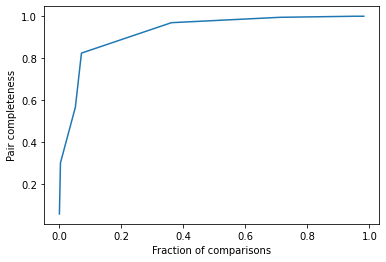

In [29]:
plt.plot(calculate_avg(fraction_comp_list2), calculate_avg(PC_list2))
plt.ylabel('Pair completeness')
plt.xlabel('Fraction of comparisons')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

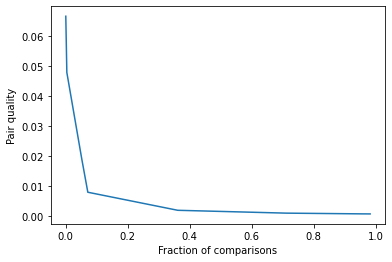

In [30]:
plt.plot(calculate_avg(fraction_comp_list2), calculate_avg(PQ_list2))
plt.ylabel('Pair quality')
plt.xlabel('Fraction of comparisons')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

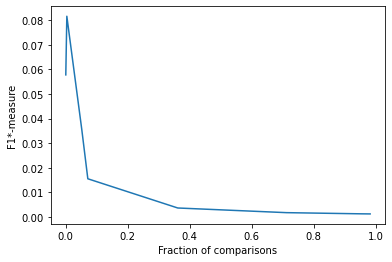

In [31]:
plt.plot(calculate_avg(fraction_comp_list2), calculate_avg(F1_star_list2))
plt.ylabel('F1*-measure')
plt.xlabel('Fraction of comparisons')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

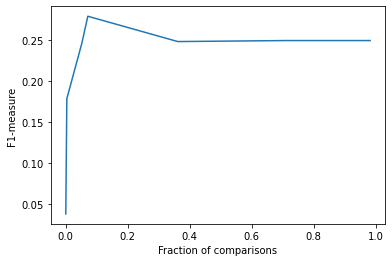

In [32]:
plt.plot(calculate_avg(fraction_comp_list2), calculate_avg(F1_MSM_list2))
plt.ylabel('F1-measure')
plt.xlabel('Fraction of comparisons')
plt.show